# GammaBayes Background Theory and Low level overview

In the previous two tutorials we touched on the main inputs that go into `GammaBayes` to get results such as the one below.

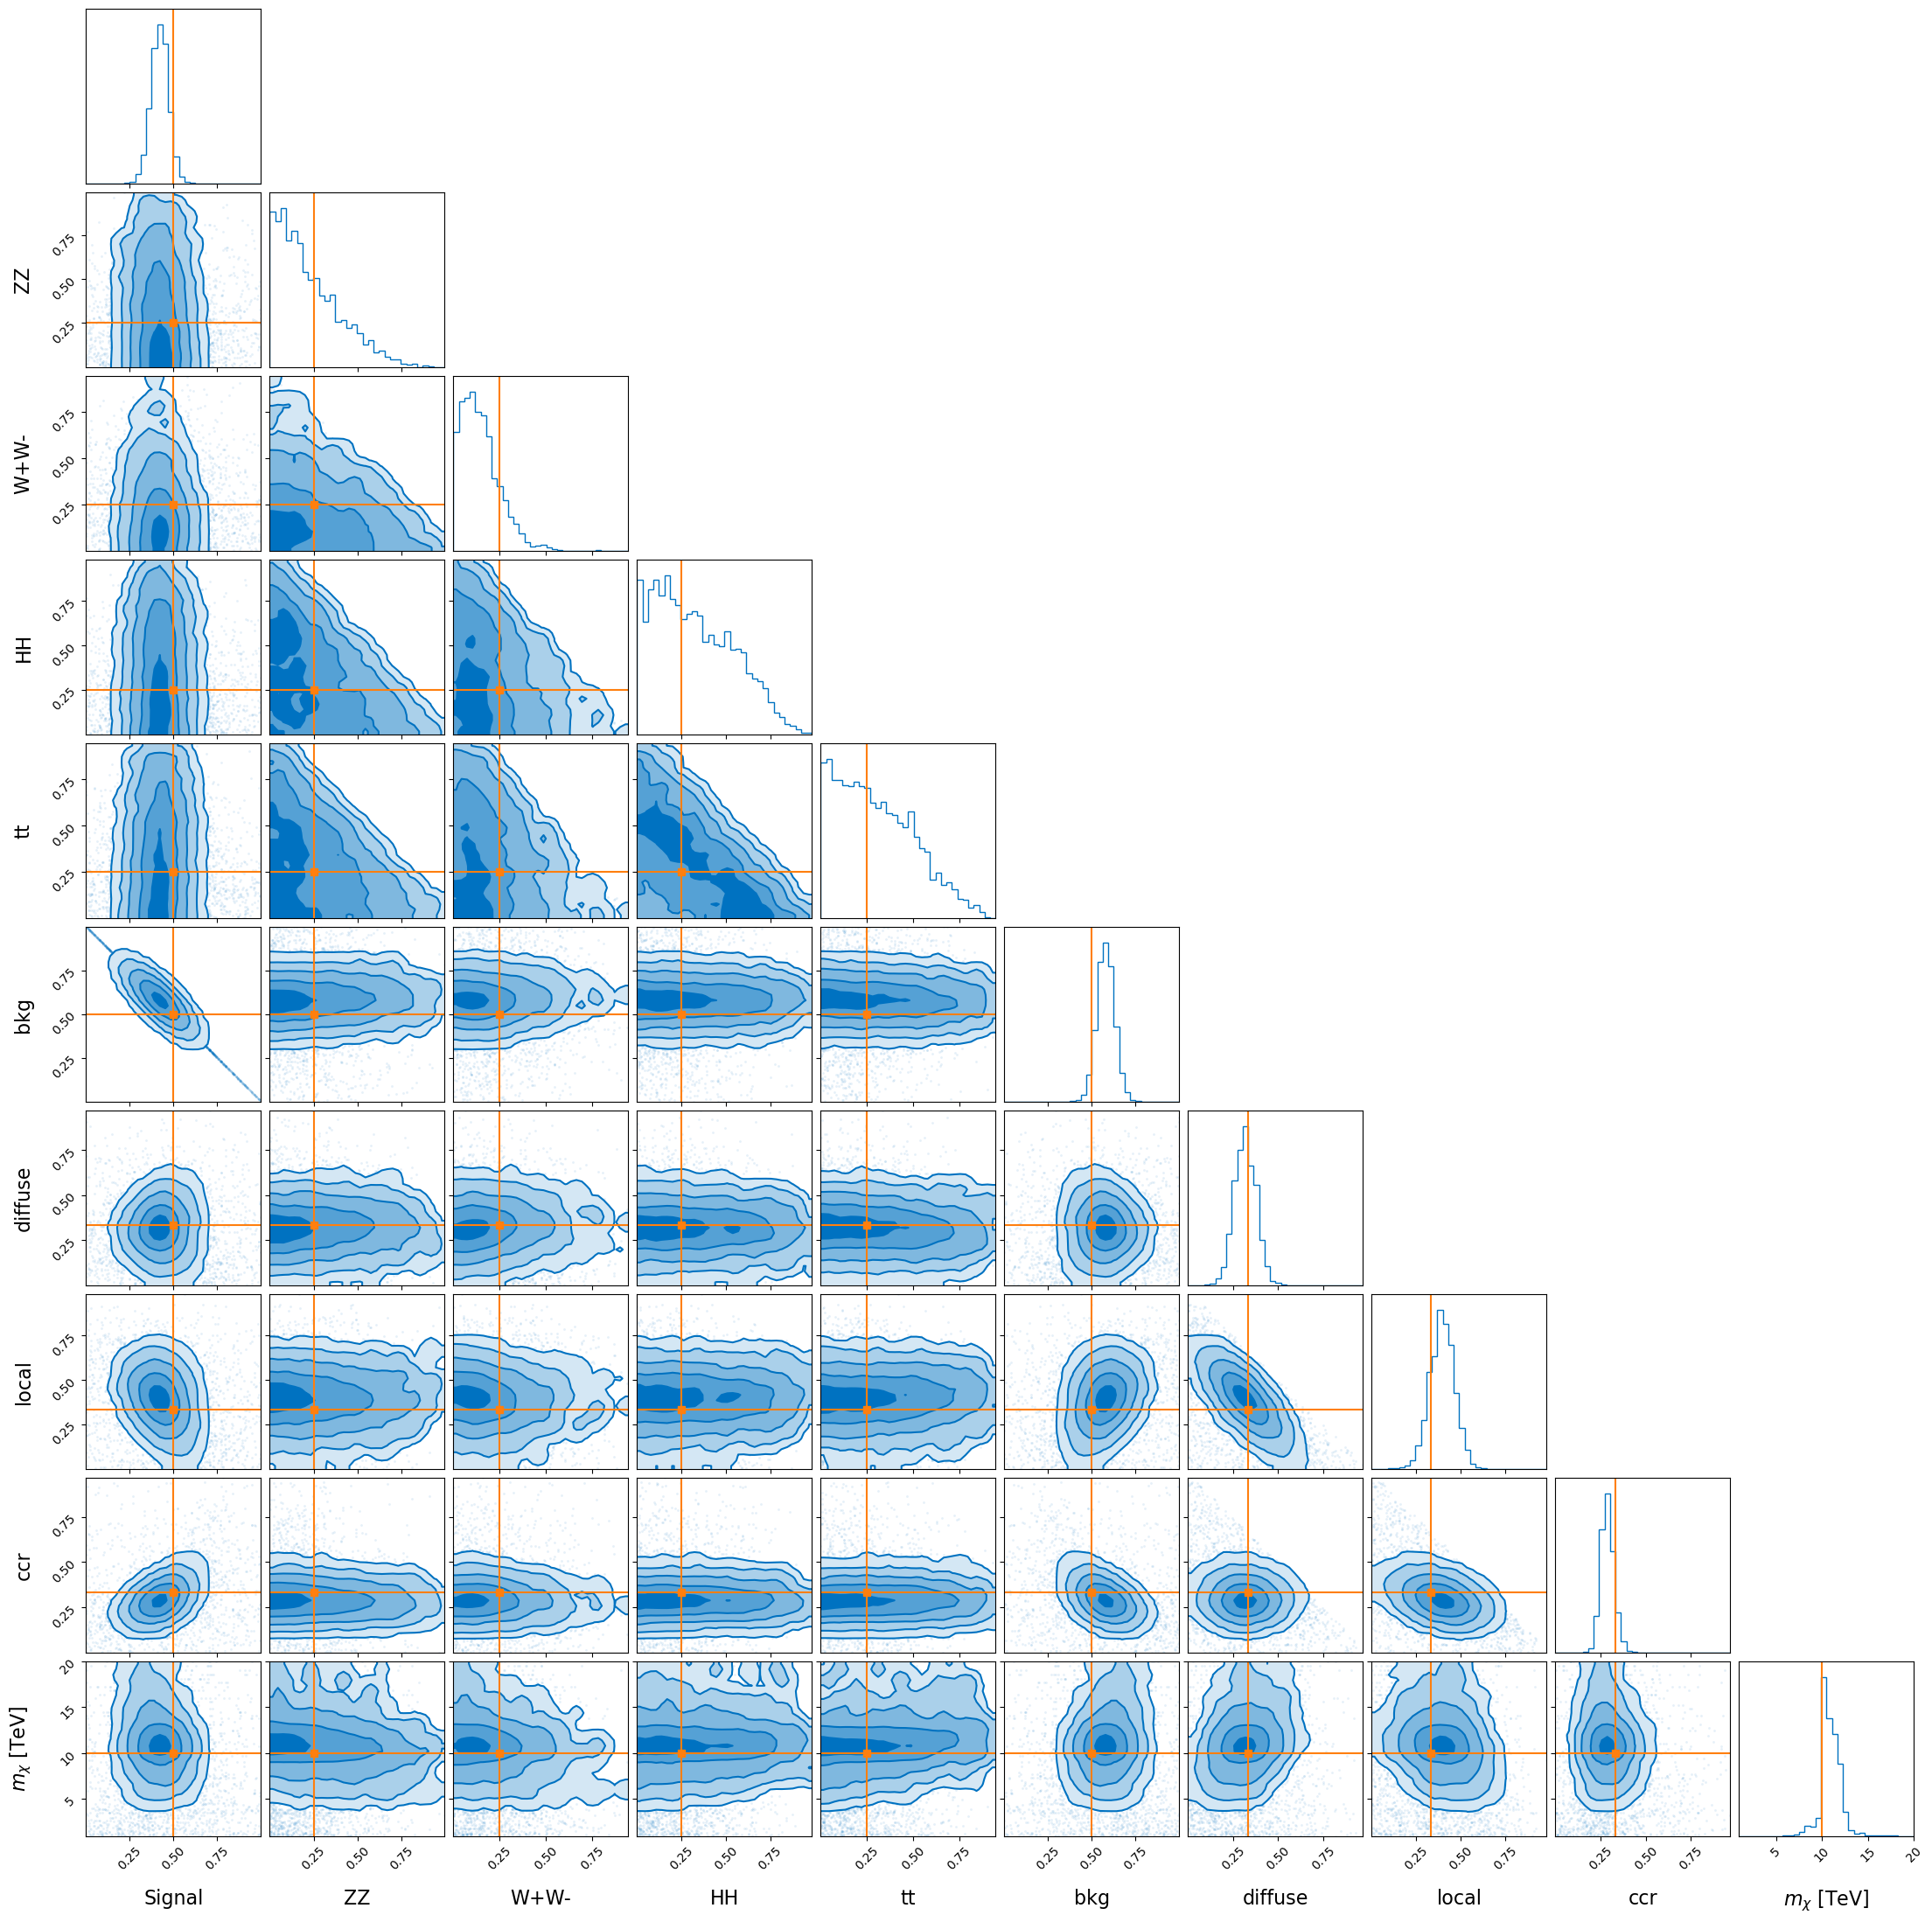

Now we will provide a more in-depth overview of the theory and how these steps come about before jumping into all the nitty gritty of each.

## The posterior and evidence

The end goal of `GammaBayes` is to calculate one of two things. 

One is the posterior, which we take as the probability of the set of parameters we are interested in, based on data, models and meta information. Formally (in extreme detail) one can write the following with the right hand side a shortened version of the left.




$$ p\left( \{\vec{\theta_i}\}_i, \vec{\alpha} {\Large|} \{\mathcal{M}_i, \vec{\phi}_i\}_i, \mathcal{M}_\alpha, \vec{d}_k, \{\mathcal{I}, \psi, t, E_{disp}, PSF, A_{eff}\}_{obs} \right) = p\left( \{\vec{\theta_i}\}_i, \vec{\alpha} {\Large|} \mathbf{\mathcal{M}}, \vec{d}_k, \mathbf{obs} \right). $$

The other is the marginalised probability or evidence, which we describe as the probability of the data once the parameters of interest (and not of interest) are _marginalised_ out. Formally, 

$$
\mathcal{Z}\left(\vec{d}_k,  {\Large|} \mathbf{\mathcal{M}}, \mathbf{obs} \right).\nonumber
$$

And these are related/calculated through the Bayes' theorem.


$$
p\left( \{\vec{\theta_i}\}_i, \vec{\alpha} {\Large|} \mathbf{\mathcal{M}}, \vec{d}_k, \mathbf{obs} \right) \nonumber

= \frac{
    \mathcal{L}\left(\vec{d}_k, {\Large|} \mathbf{\mathcal{M}}, \mathbf{obs}\right)     \pi\left(\{\vec{\theta_i}\}_i, \vec{\alpha} {\Large|}\mathbf{\mathcal{M}}, \mathbf{obs}\right)
    }{
    \mathcal{Z}\left(\vec{d}_k, {\Large|}\mathbf{\mathcal{M}}, \mathbf{obs}\right)
    } \nonumber

$$

Going through the variables involved:

- $\{E_m^k, l_m^k, b_m^k, obs^k\}_k$ are the measured energy, longitude and latitude and $obs^k$ is a reference to what observation these data points came from.

- $ \vec{\theta_i} $ are the model parameters we wish to perform inference on, $\mathcal{M}_i$ are the relevant models for these parameters and $\vec{\phi}_i$ are the fixed/constant/default parameter values

- $\vec{\alpha} $ are the mixture weights relating to how much each component contributes to the overall number of events and $\mathcal{M}_\alpha$ is the structure and models for how these parameters behave

- $\{\mathcal{I}, \psi, t, E_{disp}, PSF, A_{eff}\}_{obs}$ relate to observation information particularly for a specific instrument $\mathcal{I}$ which currently is mostly CTAO.
    - $\psi$ is the pointing direction of a given observation run
    - $t$ is the observation time of the observation run
    - $E_{disp}$ is the energy dispersion for the observation run
    - $PSF$ is the point spread function for the observation run
    - $A_{eff}$ is the model for effective area of the telescope for the observation run

The key difficulty here is calculating the likelihood or the components of the likelihood, formally written below


$$ \mathcal{L}\left(\vec{d}_k {\Large|}\mathbf{\mathcal{M}},\{\vec{\theta_i},\vec{\phi}_i\}_i, \vec{\alpha}, \mathbf{obs} \right) = \prod_k \sum_i w_i(\vec{\alpha}) \, \mathcal{L}(\vec{d}_k | \mathcal{M}_i,\vec{\theta_i}, \vec{\phi}_i, \mathbf{obs}) $$

$w_i(\vec{\alpha})$ represents the weight of a given model, it is a function of the alpha values. For example in our dark matter signal analysis we typically have an overall signal fraction $\alpha_\mathcal{S}$ and then weights for how much individual components of the signal contribute $\alpha_{\mathcal{S}j}$. In this case, for one of the signal components $w(\vec{\alpha}) = \alpha_\mathcal{S} \cdot \alpha_{\mathcal{S}j}$ with another subtle dependency between all the other $\alpha$ values through the fact that $\sum_i w(\vec{\alpha}) = 1$.

## The likelihood and nuisance marginalisation

The difficult thing about this is that $\mathcal{L}(\vec{d}_k | \mathcal{M}_i,\vec{\theta_i}, \vec{\phi}_i, \mathbf{obs})$ must be calculated for every event $\vec{d}_k$ and for each model $\mathcal{M}_i$ along with all the different combinations of the relevant model parameters $\vec{\theta}_i$. And this is not an easy calculation. $\mathcal{L}(\vec{d}_k | \mathcal{M}_i,\vec{\theta_i}, \vec{\phi}_i, \mathbf{obs})$ is defined as the evidence of the following equation,

$$ p(\vec{d^t}_k |\vec{d}_k, \mathcal{M}_i,\vec{\theta_i}, \vec{\phi}_i, \mathbf{obs}) = \frac{
    \mathcal{L}(\vec{d}_k | \vec{d^t}_k, \mathbf{obs}) \pi(\vec{d^t}_k |\mathcal{M}_i,\vec{\theta_i}, \vec{\phi}_i, \text{exposure})
    }{
        \mathcal{Z}(\vec{d}_k | \mathcal{M}_i,\vec{\theta_i}, \vec{\phi}_i, \mathbf{obs})
        } $$

which formally is defined as 


$$ \mathcal{Z}(\vec{d}_k | \mathcal{M}_i,\vec{\theta_i}, \vec{\phi}_i, \mathbf{obs}) = \int_{E^t} dE^t \int_{\Omega^t} d\Omega^t \; \mathcal{L}(\vec{d}_k | \vec{d^t}_k, \mathbf{obs}) \pi(\vec{d^t}_k |\mathcal{M}_i,\vec{\theta_i}, \vec{\phi}_i, \text{exposure}) $$

This is essentially just marginalising over the true values which are of no interest to us. So later on I will refer to this step as 'marginalisating out the nuisance parameters' or the like.

The likelihood here is purely instrumental, and currently is a product of the energy dispersion and point spread functions for the telescope. These functions are very nicely supplied by the Cherenkov Telescope Array Observatory.

`GammaBayes` is mostly involved with the integration method, the construction of the priors and ensuring that the likelihood is normalised.


You might think that performing this integral via a stochastic sampler would be the way, but currently it is faster to instead perform a parameter scan over the true parameter values and numerically integrate as it is just a three-dimensional integral. 

### An issue with memory

Because of the above we do not currently recommend using `GammaBayes` if you want to investigate more than 3 prior parameters for a single prior, if you have 10 priors and each has a single parameter that is no issue. This is because of this direct integration outputs a matrix of the log marginalisation values. 

So, if you have a prior with two independent parameters with 60 bins each then for each event this calculation would output a 3600 bin log marginalisation matrix. This might not sound like a lot, but presuming just 64-bit or 8-byte numbers and 100,000,000 events then the total memory usage would be $8\times10^8\times3600 = 2880\times10^9$ or roughly 2.88 Terrabytes! And you can imagine if you wanted three or four parameters for that specific prior.

If we compare that to 10 priors all with a parameter with 60 bins then the total memory usage would be $8\times10^8\times60\times10 = 480\times10^9$ or roughly 480 Gigabytes. This is large, but scales linearly as opposed to exponentially.

We are currently trying to develop a sample reweighting method which will allow one to circumvent this issue but the completion timeline for this is unclear.

## An overview

So in summary, what we (/`GammaBayes`) need to do is in rough order

1. Marginalise over the nuisance parameters. Which involves
    1. Describe how we will bin our energy and angular values
    2. Handle multi-observational datasets 
    3. Constructing priors based on astrophysical and observational flux models
    4. Allow easy access to the instrument response functions and subsequently observational likelihoods
    5. Deal with how observations impact our priors and likelihoods (particularly the observation time, the pointing direction of observations and the subsequent exposure maps)
    6. Evaluate and normalise the observational likelihoods on a grid of true parameter values
    7. Evaluate and normalise the priors on a mesh grid of true parameter values and prior parameters
    8. Integrate the product of the previous two steps and store these marginalised probability values
2. Explore the parameter space of the mixture parameters $\vec{\alpha}$ and model parameters $\vec{\theta}_i$ (which I will sometimes refer to as the hyper-parameters) and calculate the evidence value. Which requires
    1. Construct a mapping between the relevant parameters and the slices of the stored marginalised probability values
    2. Construction and evaluation of the hyper-parameter model likelihood
    3. Definition and evaluation of the hyper-parameter prior and prior transform (for nested sampling)


And from their one can either use the default sampling methods within GammaBayes or you can pass the prior transform and likelihood to whatever nested sampler you like (presuming that it deals with function evaluation similar to the package `dynesty`).



We have tried to design most of these steps such that if you decide you don't like how we do certain steps you can other take the results from a previous step, and do all the calculations yourself or do a particular step and then be able to easily enough put the result of said step back into the `GammaBayes` pipeline.

And you have likely already seen some higher level classes like `High_Level_Analysis` and `SimulationContainer` that in some cases will reduce the need to directly deal with the code.

Then, because `GammaBayes` is currently focused on searching for dark matter, there is a separate `dark_matter` module with some further specifically helpful class including
- `DM_ContinuousEmission_Spectrum` which allows the construction of discrete priors components from information of the partial annihilation ratios of a given dark matter model (or to look at a single emission channel although for that we instead recommend the use of `SingleDMChannel`)
- `DM_Profile` profile and it's sub-classes allow use of some common dark matter spatial profiles (currently particularly the `Einasto_Profile` class) and constructing discrete prior components over angular coordinates (currently it is essentially a wrapper for the dark matter density profiles currently within the code package `Gammapy`)
- `CombineDMComps` allows one to combine the above two components into a `SourceFluxDiscreteLogPrior` class instance
- `CustomDMRatiosModel` allows the construction of multiple single channel `SourceFluxDiscreteLogPrior` class instances

Below is a figure of how most of these classes relate to each other (with the absence of the dark matter classes so it doesn't get rediculous), there is a pdf version within the repository where this tutorial is located if you would like a better look.



<img src="Figures/GammaBayes_UML.png" alt="GammaBayes UML" width="1600"/>

In the next few tutorials we will find out how to:
- contruct and use `GammaBinning` to make dealing with coordinate axes easy
- contruct and use `GammaLogExposure` to deal with exposures (and possibly masking sources if I can get around to it)
- contruct and use `IRF_Loglikelihood` to deal with IRFs and some information to understand their place within `GammaBayes`
- contruct and use `GammaObs` and `GammaObsCube` and how we can use them to nicely deal with true and reconstructed event data and observations
- to perform simulations using `DiscreteLogPrior` classes and `IRF_Loglikelihood` classes
- use the dark matter classes within this pipeline like you would with any other sources but easier
- understand and use `Parameter`, `ParameterSet` and `ParameterSetCollection`
- perform nuisance marginalisation over the true event values and perform inference over hyperparameters of interest
- perform nuisance marginalisation over the true event values for multiple observations and how to perform inference over hyperparameters of interest using nested sampling and multi-processing
- use some useful miscellaneous utilities within `GammaBayes`
- some of next steps that we hope to take the code in the future (and if you're reading this maybe you could help out!)

And if I really have the time I'm planning to write a full developer API... we'll see how that goes.